In [ ]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=be848acfdcaef6300295ec97fc5f1a353f50b1a11a9b8258e398ea39423ecabc
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import import_ipynb
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! pwd
%cd drive/MyDrive
%cd Colab-Super_resolution/

Mounted at /content/drive
/content
/content/drive/MyDrive
/content/drive/MyDrive/Colab-Super_resolution


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-43105642-03c8-d9cf-99eb-9f3abe5f7e49)


#Loading and visualize dataset

In [ ]:
import LoadingDataset  as dataset_loader

importing Jupyter notebook from LoadingDataset.ipynb
import libary...


In [ ]:
#div2k/bicubic_x4
#div2k/unknown_x4
dataset=dataset_loader.load_dataset(key='div2k/bicubic_x4')

using tensorflow_datasets to load the dataset 
loading dataset...
EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incomplete16AIU9/div2k-train.tfrecord


  0%|          | 0/800 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incomplete16AIU9/div2k-validation.tfrecord


  0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='div2k',
    version=2.0.0,
    description='DIV2K dataset: DIVerse 2K resolution high quality images as used for the challenges @ NTIRE (CVPR 2017 and CVPR 2018) and @ PIRM (ECCV 2018)',
    homepage='https://data.vision.ee.ethz.ch/cvl/DIV2K/',
    features=FeaturesDict({
        'hr': Image(shape=(None, None, 3), dtype=tf.uint8),
        'lr': Image(shape=(None, None, 3), dtype=tf.uint8),
    }),
    total_num_examples=900,
    splits={
        'train': 800,
        'validation': 100,
    },
    supervised_keys=('lr', 'hr'),
    citation="""@InProceedings{Agustsson_2017_CVPR_Workshops,
    	author = {Agustsson, Eirikur and Timofte, Radu},
    	title = {NTIRE 2017 Challenge on Single Image Super-Resolution: Dataset and Study},
    	booktitle = {The IEEE Conference on Computer Vision and Pattern Recognition (CVPR) Workshops},


In [ ]:
(train, validate) ,meta = dataset

**Preprocessing data**

First we need to random crop whole dataset with specific spartial size

In [ ]:
cropped_size = 256
batch_size = 8
train = train.map(lambda lr,hr:(dataset_loader.random_crop(lr,hr,cropped_size,4)), num_parallel_calls=tf.data.AUTOTUNE)

Secondly normalize input, implement data augmentation and configure performan for training

In [ ]:
train = train.map(lambda lr,hr:( dataset_loader.normalize_img(lr),dataset_loader.normalize_img(hr)), num_parallel_calls=tf.data.AUTOTUNE)
train = train.map(dataset_loader.augment,num_parallel_calls=tf.data.AUTOTUNE)
train = dataset_loader.configure_performan(train,BUFFER_SIZE=800,BATCH_SIZE=batch_size)

Normalizes images: `uint8` -> `float32`
Normalizes images: `uint8` -> `float32`


In [ ]:
train = train.repeat(5)

In [ ]:
validate = validate.map(lambda lr,hr:(dataset_loader.random_crop(lr,hr,cropped_size,4)), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
validate = validate.map(lambda lr,hr:( dataset_loader.normalize_img(lr),dataset_loader.normalize_img(hr)), num_parallel_calls=tf.data.AUTOTUNE)
# train = train.map(dataset_loader.augment,num_parallel_calls=tf.data.AUTOTUNE)
validate = dataset_loader.configure_performan(validate,BUFFER_SIZE=100,BATCH_SIZE=batch_size)

Normalizes images: `uint8` -> `float32`
Normalizes images: `uint8` -> `float32`


In [ ]:
validate = validate.repeat(5)

In [ ]:
ge = tf.random.get_global_generator()
ge.uniform([1],minval=1,maxval=255,dtype=tf.dtypes.int32)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([169], dtype=int32)>

In [ ]:
d = tf.data.Dataset.from_tensor_slices([1, 1, 1])
d=d.map(lambda x: x+generator.uniform([1],minval=1,maxval=255,dtype=tf.dtypes.int32),num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for i in d.repeat(100).take(100):
  print(i[0])

In [ ]:
print(len(train))
print(len(validate))

500
65


**Visualize data**

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [ ]:
count=0
for i in train.take(1):
  count=count+1
  # tf.keras.utils.save_img(
  #       '/content/drive/MyDrive/Image-sr/img{}.{}'.format(str(count),'jpeg'), tf.image.random_jpeg_quality(i[1],20,30)
  # )
  # tf.keras.utils.save_img(
  #       '/content/drive/MyDrive/Image-sr/img{}.png'.format(str(count)+'blur'),tfa.image.gaussian_filter2d(i[1],filter_shape= (9, 9),sigma=2)
  # )
  # tf.keras.utils.save_img(
  #       '/content/drive/MyDrive/Image-sr/img{}.png'.format(str(count)+'origin'), i[1]
  # )
  dataset_loader.show( tf.image.random_jpeg_quality(i[1],20,30) ,'Low resolution')
  dataset_loader.show(tfa.image.gaussian_filter2d(i[1],filter_shape= (9, 9),sigma=2) ,'Low resolution')
  dataset_loader.show(i[1] ,'Low resolution')
  # dataset_loader.show(i[0][0],'High resolution')
  # dataset_loader.show(generator(i[0])[0],'Low resolution')
  # dataset_loader.show(generator(tf.expand_dims(i[1],axis=0))[0],'High resolution')

In [ ]:
train=train.batch(1)

In [ ]:
for i in train.take(3):

  dataset_loader.show(tf.image.resize(i[1][0], [i[1][0].shape[0]*4,i[1][0].shape[1]*4], method=tf.image.ResizeMethod.BICUBIC),'Low resolution')
  dataset_loader.show(generator(tf.expand_dims(i[1][0],axis=0))[0],'Super resolution')
  dataset_loader.show(i[1][0],'High resolution')



In [ ]:
for i in train.take(1):
  print('---------------Feature_Loss--------------')
  print(tf.reduce_mean(feature_loss(generator(i[0]),i[1])))
  print(tf.reduce_mean(feature_loss(generator2(i[0]),i[1])))
  print('---------------Style_Loss--------------')
  print(tf.reduce_mean(style_loss(generator(i[0]),i[1])))
  print(tf.reduce_mean(style_loss(generator2(i[0]),i[1])))
  print('---------------PSNR--------------')
  print(tf.reduce_mean(tf.image.psnr(generator(i[0]),i[1],max_val=1)))
  print(tf.reduce_mean(tf.image.psnr(generator2(i[0]),i[1],max_val=1)))
  # print(tf.reduce_mean(tf.image.psnr(tf.image.resize(i[0][0], [i[0][0].shape[0]*4,i[0][0].shape[1]*4], method=tf.image.ResizeMethod.BICUBIC),i[1][0],max_val=1)))
  print('---------------SSIM--------------')
  print(tf.reduce_mean(tf.image.ssim(generator(i[0]),i[1],max_val=1)))
  print(tf.reduce_mean(tf.image.ssim(generator2(i[0]),i[1],max_val=1)))
  # print(tf.reduce_mean(tf.image.psnr(tf.image.resize(i[0][0], [i[0][0].shape[0]*4,i[0][0].shape[1]*4], method=tf.image.ResizeMethod.BICUBIC),i[1][0],max_val=1)))
  print('---------------')

  dataset_loader.show(tf.image.resize(i[0][0], [i[0][0].shape[0]*4,i[0][0].shape[1]*4], method=tf.image.ResizeMethod.BICUBIC),'Low resolution')
  dataset_loader.show(generator(tf.expand_dims(i[0][0],axis=0))[0],'Super resolution')
  dataset_loader.show(generator2(tf.expand_dims(i[0][0],axis=0))[0],'Super resolution2')
  dataset_loader.show(i[1][0],'High resolution')



In [ ]:
def random_crop(lr_img, hr_img, hr_crop_size, scale):
    lr_crop_size = hr_crop_size // scale
    lr_shape = tf.shape(lr_img)[:2]
    lr_top = tf.random.uniform(shape=(), maxval=lr_shape[0] - lr_crop_size + 1, dtype=tf.int32)
    lr_left = tf.random.uniform(shape=(), maxval=lr_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    hr_top = lr_top * scale
    hr_left = lr_left * scale
    lr_crop = lr_img[lr_top:lr_top + lr_crop_size, lr_left:lr_left + lr_crop_size]
    hr_crop = hr_img[hr_top:hr_top + hr_crop_size, hr_left:hr_left + hr_crop_size]
    return lr_crop, hr_crop

In [ ]:
s={}
s['psnr']=[]
s['ssim']=[]
for i in train.take(2):
  s['psnr'].append(tf.reduce_mean(tf.image.psnr(generator(i[0]),i[1],max_val=1)))
  s['ssim'].append(tf.reduce_mean(tf.image.ssim(generator(i[0]),i[1],max_val=1)))
print(s)

##Setup for training PSNR Oriented

In [ ]:
import ModuleArchitecture as architecture
import tensorflow as tf

importing Jupyter notebook from ModuleArchitecture.ipynb


Building Generator model by calling API funciton from ModuleArchitecture notebook.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add, Lambda, LeakyReLU, Flatten, Dense,PReLU,Concatenate
from tensorflow.keras.layers import PReLU
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

In [ ]:
generator = architecture.build_generator(kn_construc=3,no_dense_per_res=2,no_dense=5,no_resblock=12,no_filter=96)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_extraction (Conv2D)       (None, None, None,   2688        ['img[0][0]']                    
                                96)                                                               
                                                                                                  
 PRelu_conv_extraction (PReLU)  (None, None, None,   96          ['conv_extraction[0][0]']        
                                96)                                                       

In [ ]:
generator2 = architecture.build_generator(kn_construc=3,no_dense_per_res=2,no_dense=5,no_resblock=12,no_filter=96)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_extraction (Conv2D)       (None, None, None,   2688        ['img[0][0]']                    
                                96)                                                               
                                                                                                  
 PRelu_conv_extraction (PReLU)  (None, None, None,   96          ['conv_extraction[0][0]']        
                                96)                                                       

In [ ]:
#counting number of layer
no_conv,no_add,no_concatenate,no_activation=0,0,0,0
for i in range(len(generator.layers)):
  if(type(generator.layers[i])==keras.layers.Concatenate):
    no_concatenate=no_concatenate+1
  if(type(generator.layers[i])==keras.layers.Add):
    no_add=no_add+1
  if(type(generator.layers[i])==keras.layers.PReLU):
    no_activation=no_activation+1
  if(type(generator.layers[i])==keras.layers.Conv2D):
    no_conv=no_conv+1
print('total layer: ',len(generator.layers))
print('conv_layer:',no_conv)
print('Add_layer:',no_add)
print('Concatenate_layer:',no_concatenate)
print('Activation_layer:',no_activation)

total layer:  398
conv_layer: 126
Add_layer: 37
Concatenate_layer: 96
Activation_layer: 100


In [ ]:
generator.get_layer('PRelu_mapping_after_upsample').get_weights()

[array([[[ 0.09708995,  0.18811636, -0.00374528,  0.13178068,
           0.17933126,  0.0871146 ,  0.11850844,  0.16265695,
           0.21831256,  0.27243996, -0.01134351,  0.12343211,
          -0.01381451,  0.1673958 ,  0.16602845,  0.2303806 ,
           0.18504055,  0.00394089,  0.19586936, -0.00936568,
           0.17029805,  0.00910245,  0.1911557 ,  0.20542301,
          -0.00127325,  0.16844305,  0.19233933,  0.3105984 ,
           0.21745972,  0.28984323, -0.02004208,  0.23469198,
           0.1421136 ,  0.18878904,  0.07278961,  0.21963374,
          -0.0166153 , -0.02015087,  0.0183213 ,  0.1891022 ,
           0.21523447,  0.12397896,  0.18535292, -0.00430572,
           0.1324601 , -0.01708299,  0.00407201,  0.23034711,
           0.18221784,  0.37516034,  0.11967883,  0.41131184,
           0.08779057,  0.21991692,  0.27278334,  0.09713565,
           0.1755587 ,  0.18535456,  0.18564738, -0.00155821,
          -0.00429496,  0.2068065 ,  0.1223004 ,  0.26961774,
        

In [ ]:
generator.save('/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Model/Generator/generator_96')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Model/Generator/generator_96/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Model/Generator/generator_96/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
tf.keras.utils.plot_model(generator, "generator.png", show_shapes=True, expand_nested=True)

First we need to train generator seperately with discriminator by MAE and then train it with feature loss and style loss, creating subclass model to do it.

In [ ]:
class Generator_implementation(tf.keras.Model):
  def __init__(self,generator,only_contentloss=True):
    super(Generator_implementation,self).__init__()
    self.generator=generator
    self.only_contentloss=only_contentloss
  def compile(
        self,
        content_loss,
        feature_loss,
        style_loss,
        alpha,
        beta,
        gamma,
        psnr,
        ssim,
        g_optimizer,
    ):
        super(Generator_implementation, self).compile()
        self.content_loss = content_loss
        self.feature_loss = feature_loss
        self.style_loss=style_loss
        self.g_optimizer = g_optimizer
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.psnr=psnr
        self.ssim=ssim
  # @#property
  # def metrics(self):
  #       # We list our `Metric` objects here so that `reset_states()` can be
  #       # called automatically at the start of each epoch
  #       # or at the start of `evaluate()`.
  #       # If you don't implement this property, you have to call
  #       # `reset_states()` yourself at the time of your choosing.
  #       return [self.psnr, self.ssim]    
  def train_step(self,batch_data):
    low_img,high_img=batch_data
    if(self.only_contentloss):
      with tf.GradientTape() as tape:
            super_img = self.generator(low_img)
            ct_loss = self.content_loss(super_img,high_img)
      grads = tape.gradient(ct_loss, self.generator.trainable_variables)
      self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
      return {'content_loss':ct_loss}
    else:        
      with tf.GradientTape() as tape:
              super_img = self.generator(low_img)
              ct_loss = self.alpha*self.content_loss(super_img,high_img)
              ft_loss = self.beta*self.feature_loss(super_img,high_img)
              s_loss = self.gamma*self.style_loss(super_img,high_img)
              loss = ct_loss + ft_loss + s_loss
      grads = tape.gradient(loss, self.generator.trainable_variables)
      self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
      return {'content_loss':ct_loss,
              'feature_loss':ft_loss,
              'style_loss':s_loss}

In [ ]:
generator_monitor=Generator_implementation(generator2,only_contentloss=False)

**Compile model and creating the checkpoint for generator**

Content loss by MAE

In [ ]:
content_loss=architecture.loss_compute(type='l1')
# content_loss=architecture.loss_compute(type='l2')

Feature loss from both high and low feature from VGG19

In [ ]:
feature_loss=architecture.build_featureloss(alpha1=0.5,alpha2=0.5)

Style loss from 4 layers (5th, 10th, 15th, 20th) 

In [ ]:
style_loss=architecture.build_styleloss()

In [ ]:
ssim_metric = architecture.ssim_metrics()
psnr_metric =architecture.psnr_metrics()

###Create the checkpoint for training generator processes at Stage 1

In [ ]:
import pandas as pd
class Generator_implementation_Callbacks(tf.keras.callbacks.Callback):
    def __init__(self, validate, generator,ckpt,file_name='/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Logger_History/Stage1/validate_metrics.csv'):
      self.validate = validate
      self.generator=generator
      self.file_name=file_name
      self.ckpt = ckpt
    def on_epoch_begin(self, epoch, logs=None):
      if(epoch!=0):
        for i in self.validate.take(1):
          #  dataset_loader.show(tf.image.resize(i[0][0], [i[0][0].shape[0]*4,i[0][0].shape[1]*4], method=tf.image.ResizeMethod.BICUBIC),'Low resolution')
          dataset_loader.show(self.generator(tf.expand_dims(i[0][0],axis=0))[0],'Low resolution')
          dataset_loader.show(i[1][0],'High resolution')
    def on_epoch_end(self, epoch, logs=None):
        psnr = tf.get_static_value(tf.reduce_mean([psnr_metric(self.generator(sr),hr) for sr,hr in self.validate.take(len(self.validate))]))
        ssim = tf.get_static_value(tf.reduce_mean([ssim_metric(self.generator(sr),hr) for sr,hr in self.validate.take(len(self.validate))]))
        header=False
        if(self.ckpt.step==0):
          print('\nCreating csv file for validate')
          header=True
          data={'step':[self.ckpt.step.numpy()],'psnr':[psnr],'ssim':[ssim]}
        else:  
          data={'step':[self.ckpt.step.numpy()],'psnr':[psnr],'ssim':[ssim]}
        frame=pd.DataFrame(data)
        frame.to_csv( self.file_name, mode='a', header=header, index=False)
        print('\nval_sim: {} ; val_psnr: {}'.format(
            str(ssim),str(psnr)))
        print('\nleanring rate:{}'.format(str(self.ckpt.g_optimizer.learning_rate)))
        print('\n'+str(logs))

In [ ]:
import time
class Checkpoint_callbacks(tf.keras.callbacks.Callback):
    def __init__(self,manager,ckpt,epochs=10,decay_step=50,decay_factor=0.5):
      self.manager=manager
      self.ckpt=ckpt
      self.epochs=epochs
      self.decay_step = decay_step
      self.decay_factor =  decay_factor
      self.start_time=time.time()
    def on_train_begin(self, logs=None):
      self.ckpt.restore(self.manager.latest_checkpoint)
      self.start_time=time.time()
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")
    def on_train_end(self, logs=None):
      duration = (time.time() - self.start_time)/60
      self.ckpt.time.assign_add(duration)
      save_path = self.manager.save()
      print("\nSaved checkpoint for final step {}: {}".format(int(self.ckpt.step), save_path))
    def on_epoch_end(self, epoch, logs=None):
     self.ckpt.step.assign_add(1)
     #make decay learning rate, decay by decay_step and decay_factor lr(1-a)**step
     if int(self.ckpt.step) % self.decay_step == 0:
        lr_current = self.ckpt.g_optimizer.learning_rate
        self.ckpt.g_optimizer.learning_rate = lr_current*(1 - self.decay_factor)**(int(self.ckpt.step) / self.decay_step)
        print('\ndecay learning rate: {}'.format(self.ckpt.g_optimizer.learning_rate))
        
     if int(self.ckpt.step) % self.epochs == 0:
      duration = (time.time() - self.start_time)/60
      self.ckpt.time.assign_add(duration)
      self.start_time = time.time()
      save_path = self.manager.save()
      print("\nSaved checkpoint for step {}: {}".format(int(self.ckpt.step), save_path))
    


In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Checkpoint_weight/Generator/ckpt_12_96"
g_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
ckpt = tf.train.Checkpoint(step=tf.Variable(0),time=tf.Variable(0.),generator=generator,g_optimizer=g_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)
generator_callback=Checkpoint_callbacks(ckpt=ckpt,manager=ckpt_manager,epochs=3,decay_step=30,decay_factor=0.5)

In [ ]:
ckpt.step
ckpt.g_optimizer.learning_rate
ckpt_manager.checkpoints

['/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Checkpoint_weight/Generator/ckpt_12_96/ckpt-41',
 '/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Checkpoint_weight/Generator/ckpt_12_96/ckpt-42']

In [ ]:
# save_path = ckpt_manager.save()
# ckpt.g_optimizer.learning_rate=2e-6
# ckpt.step
ckpt.restore(
  ckpt_manager.latest_checkpoint)

In [ ]:
checkpoint_path_stage2 = "/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Checkpoint_weight/Generator/ckpt_12_96_stage2_2"
g_optimizer_stage2  = ckpt.g_optimizer
ckpt_stage2  = tf.train.Checkpoint(step=tf.Variable(0),time=tf.Variable(0.),generator=generator2,g_optimizer=g_optimizer_stage2 )
ckpt_manager_stage2  = tf.train.CheckpointManager(ckpt_stage2 , checkpoint_path_stage2 , max_to_keep=2)
generator_callback_stage2 =Checkpoint_callbacks(ckpt=ckpt_stage2 ,manager=ckpt_manager_stage2 ,epochs=3,decay_step=30,decay_factor=0.5)

In [ ]:
ckpt_stage2.restore(ckpt_manager_stage2.latest_checkpoint)

In [ ]:
ckpt_stage2.g_optimizer.learning_rate=1e-4

In [ ]:
save_path = ckpt_manager_stage2.save()

**Compile Subclass model**

In [ ]:
generator_monitor.compile(
    content_loss=content_loss,
    g_optimizer=g_optimizer,
    feature_loss=feature_loss,
    style_loss=style_loss,
    alpha=1,
    beta=2e-4,
    gamma=2e-5,
    psnr=psnr_metric,
    ssim=ssim_metric)

In [ ]:
6000*(2e-6)

0.012

In [ ]:
callback_monitor_stage2=Generator_implementation_Callbacks(validate,generator2,ckpt_stage2,file_name='/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Logger_History/Stage1/validate_metrics_stage2_2.csv')
csv_logger_stage2 = tf.keras.callbacks.CSVLogger(
    '/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Logger_History/Stage1/ESRGAN_12r_96_stage2_2.csv'
    ,',',append=True)

Set up epochs, step and training

In [ ]:
#,callbacks=[callback_monitor,generator_callback,csv_logger
history=generator_monitor.fit(train,steps_per_epoch=500,epochs=20,initial_epoch=0,callbacks=[callback_monitor_stage2,generator_callback_stage2,csv_logger_stage2])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
ckpt.g_optimizer.learning_rate

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=5e-05>

In [ ]:
psnr=[]
ssim=[]
ct_loss=[]
ft_loss=[]
s_loss=[]
for i in range(1):
  psnr.append(tf.reduce_mean([psnr_metric(generator(sr),hr) for sr,hr in validate.take(len(validate))]))
  print()
  ssim.append(tf.reduce_mean([ssim_metric(generator(sr),hr) for sr,hr in validate.take(len(validate))]))
  print()
  ct_loss.append(tf.reduce_mean([content_loss(generator(sr),hr) for sr,hr in validate.take(len(validate))]))
  print()
  ft_loss.append(tf.reduce_mean([feature_loss(generator(sr),hr) for sr,hr in validate.take(len(validate))]))
  print()
  s_loss.append(tf.reduce_mean([style_loss(generator(sr),hr) for sr,hr in validate.take(len(validate))]))
  print()

In [ ]:
print(psnr,ssim,ct_loss,ft_loss,s_loss)

[<tf.Tensor: shape=(), dtype=float32, numpy=27.572035>] [<tf.Tensor: shape=(), dtype=float32, numpy=0.7303729>] [<tf.Tensor: shape=(), dtype=float32, numpy=0.03481732>] [<tf.Tensor: shape=(), dtype=float32, numpy=769.6662>] [<tf.Tensor: shape=(), dtype=float32, numpy=6218.319>]


In [ ]:
ckpt.step

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=70>

In [ ]:
2e-4*600

0.12000000000000001

In [ ]:
tf.reduce_mean([style_loss(generator2(sr),hr) for sr,hr in validate.take(len(validate))])

<tf.Tensor: shape=(), dtype=float32, numpy=3648.3186>

In [ ]:
tf.reduce_mean([psnr_metric(generator2(sr),hr) for sr,hr in validate.take(len(validate))])

<tf.Tensor: shape=(), dtype=float32, numpy=28.527393>

In [ ]:
tf.reduce_mean([psnr_metric(generator(sr),hr) for sr,hr in validate.take(len(validate))])

<tf.Tensor: shape=(), dtype=float32, numpy=29.206888>

In [ ]:
print(tf.reduce_mean(psnr))
print(tf.reduce_mean(ssim))
print(tf.reduce_mean(ct_loss))
print(tf.reduce_mean(ft_loss))
print(tf.reduce_mean(s_loss))

tf.Tensor(28.554222, shape=(), dtype=float32)
tf.Tensor(0.7612224, shape=(), dtype=float32)
tf.Tensor(0.0310861, shape=(), dtype=float32)
tf.Tensor(690.6313, shape=(), dtype=float32)
tf.Tensor(4469.284, shape=(), dtype=float32)


In [ ]:
tf.reduce_mean()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

In [ ]:
history

In [ ]:
plt.plot(history.history['feature_loss'])
# plt.plot(history.history['feature_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['content_loss'], loc='upper left')
plt.show()
plt.plot(history.history['feature_loss'])
# plt.plot(history.history['feature_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['content_loss'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd

In [ ]:
his['content_loss'].values.tolist()

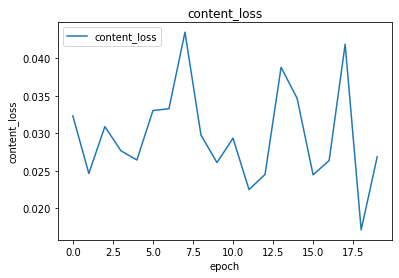

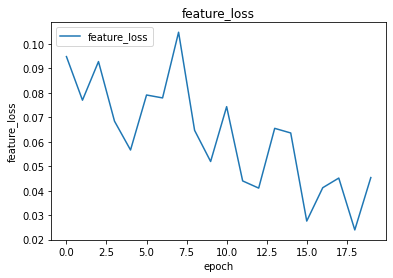

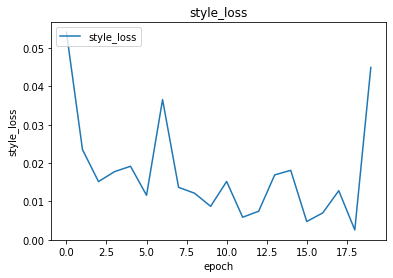

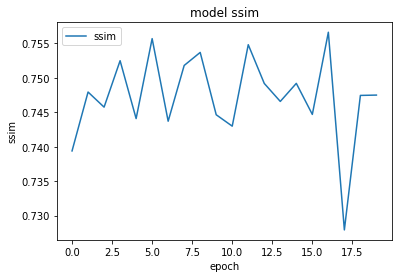

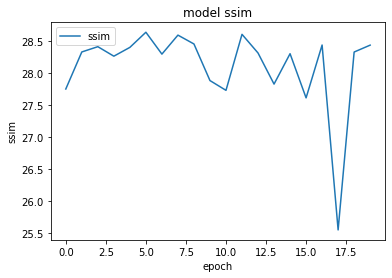

In [ ]:
plt.plot(loss['content_loss'].values.tolist())
# plt.plot(history.history['feature_loss'])
plt.title('content_loss')
plt.ylabel('content_loss')
plt.xlabel('epoch')
plt.legend(['content_loss'], loc='upper left')
plt.show()
plt.plot(loss['feature_loss'].values.tolist())
# plt.plot(history.history['feature_loss'])
plt.title('feature_loss')
plt.ylabel('feature_loss')
plt.xlabel('epoch')
plt.legend(['feature_loss'], loc='upper left')
plt.show()
plt.plot(loss['style_loss'].values.tolist())
# plt.plot(history.history['feature_loss'])
plt.title('style_loss')
plt.ylabel('style_loss')
plt.xlabel('epoch')
plt.legend(['style_loss'], loc='upper left')
plt.show()
plt.plot(his['ssim'].values.tolist())
# plt.plot(history.history['feature_loss'])
plt.title('model ssim')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['ssim'], loc='upper left')
plt.show()
plt.plot(his['psnr'].values.tolist())
# plt.plot(history.history['feature_loss'])
plt.title('model ssim')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['ssim'], loc='upper left')
plt.show()

In [ ]:
his = pd.read_csv(
    "/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Logger_History/Stage1/validate_metrics_stage2.csv")
loss = pd.read_csv(
    "/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Logger_History/Stage1/ESRGAN_12r_96_stage2.csv")

In [ ]:
discriminator = architecture.build_discriminator()

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator
  def compile(
        self,
        content_loss,
        feature_loss,
        style_loss,
        g_loss,
        d_loss,
          alpha,
        beta,
        gamma,
        sigma,
        lamda,
        g_optimizer,
        d_optimizer,
    ):
        super(GAN, self).compile()
        self.content_loss = content_loss
        self.feature_loss = feature_loss
        self.style_loss = style_loss
        self.g_loss = g_loss
        self.d_loss = d_loss
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.sigma=sigma
        self.lamda=lamda
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
  def train_step(self,batch_data):
    low_img,high_img=batch_data
    with tf.GradientTape(persistent=True) as tape:
       super_img  = self.generator(low_img)

       predict_sr = self.discriminator(super_img)
       predict_hr = self.discriminator(high_img)

       ct_loss  = self.alpha*self.content_loss(super_img,high_img) 
       ft_loss  = self.beta*self.feature_loss(super_img,high_img)
       st_loss  = self.gamma*self.style_loss(super_img,high_img)
       g_loss = self.sigma*self.g_loss(predict_sr,predict_hr)
       generator_loss = ct_loss + ft_loss + st_loss + g_loss
       d_loss = self.lamda*self.d_loss(predict_sr,predict_hr)
    grads_G = tape.gradient(
            generator_loss, generator.trainable_variables)
    grads_D = tape.gradient(
            d_loss, discriminator.trainable_variables) 
    self.g_optimizer.apply_gradients(
            zip(grads_G, generator.trainable_variables))
    self.d_optimizer.apply_gradients(
            zip(grads_D, discriminator.trainable_variables))
    return {
        'content_loss':ct_loss,
        'feature_loss':ft_loss,
        'style_loss':st_loss,
        'g_loss':g_loss,
        'd_loss':d_loss,
        'gan_loss':g_loss+d_loss
    }


In [ ]:
gan = GAN(generator=generator,discriminator=discriminator)
content_loss=architecture.loss_compute(type='l1')
feature_loss=architecture.feature_loss()
style_loss=architecture.style_loss()
g_loss=architecture.generator_loss(with_relativistic=False)
d_loss=architecture.discriminator_loss(with_relativistic=False)
d_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
g_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
gan.compile(content_loss=content_loss,feature_loss=feature_loss,style_loss=style_loss,g_loss=g_loss,d_loss=d_loss
            ,alpha=1e+2
            ,beta=2e-6
            ,gamma=2e-6
            ,sigma=1
            ,lamda=1
            ,d_optimizer=d_optimizer,g_optimizer=g_optimizer)

In [ ]:
def random_crop(lr_img, hr_img, hr_crop_size, scale):
    lr_crop_size = hr_crop_size // scale
    lr_shape = tf.shape(lr_img)[:2]
    lr_top = tf.random.uniform(shape=(), maxval=lr_shape[0] - lr_crop_size + 1, dtype=tf.int32)
    lr_left = tf.random.uniform(shape=(), maxval=lr_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    hr_top = lr_top * scale
    hr_left = lr_left * scale
    lr_crop = lr_img[lr_top:lr_top + lr_crop_size, lr_left:lr_left + lr_crop_size]
    hr_crop = hr_img[hr_top:hr_top + hr_crop_size, hr_left:hr_left + hr_crop_size]
    return lr_crop, hr_crop

In [ ]:
hs=gan.fit(train.repeat(4),steps_per_epoch=1000,epochs=10)

Epoch 1/10
1000/1000 [==============================] - 560s 462ms/step - content_loss: 2.3633 - feature_loss: 0.0712 - style_loss: 2.7944e-04 - g_loss: 0.7753 - d_loss: 1.3261 - gan_loss: 2.1014
Epoch 2/10
1000/1000 [==============================] - 462s 462ms/step - content_loss: 1.9333 - feature_loss: 0.0387 - style_loss: 1.0670e-04 - g_loss: 0.7760 - d_loss: 1.3175 - gan_loss: 2.0935
Epoch 3/10
1000/1000 [==============================] - 462s 462ms/step - content_loss: 1.9047 - feature_loss: 0.0362 - style_loss: 9.9546e-05 - g_loss: 0.7998 - d_loss: 1.2988 - gan_loss: 2.0986
Epoch 4/10
1000/1000 [==============================] - 462s 462ms/step - content_loss: 2.3219 - feature_loss: 0.0539 - style_loss: 1.6987e-04 - g_loss: 0.9546 - d_loss: 1.2094 - gan_loss: 2.1641
Epoch 5/10
1000/1000 [==============================] - 462s 462ms/step - content_loss: 2.4558 - feature_loss: 0.0624 - style_loss: 1.6397e-04 - g_loss: 1.2800 - d_loss: 0.9984 - gan_loss: 2.2785
Epoch 6/10
 140/1000

KeyboardInterrupt: ignored

In [ ]:
hs.history

{'content_loss': [1.2923823595046997, 1.3645026683807373],
 'd_loss': [1.3851957321166992, 1.3326733112335205],
 'feature_loss': [0.02255326323211193, 0.01965775527060032],
 'g_loss': [0.6565059423446655, 0.8024784326553345],
 'gan_loss': [2.0417017936706543, 2.1351518630981445],
 'style_loss': [5.703381248167716e-05, 1.8622346033225767e-05]}

#Implement checkpoint and restored model

In [ ]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=net, iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

In [ ]:
class Gan_Callbacks(tf.keras.callbacks.Callback):
    def __init__(self,manager):
      self.manager=manager
    def on_epoch_end(self, epoch, logs=None):
        print(logs)

#Implement Training Step
 